In [2]:
from os import listdir
from os.path import join, isdir

import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)


path_to_raw_eeg = '../../converted_data'
path_to_figures = './figures'

20
Creating RawArray with float64 data, n_channels=65, n_times=676207
    Range : 0 ... 676206 =      0.000 ...   676.206 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge

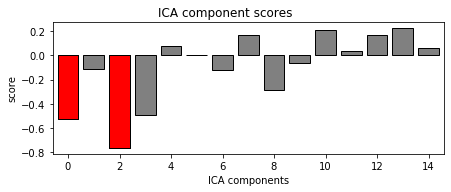

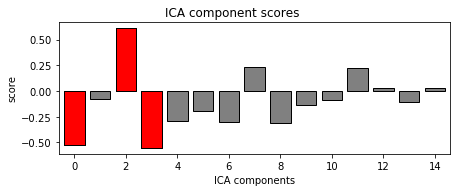

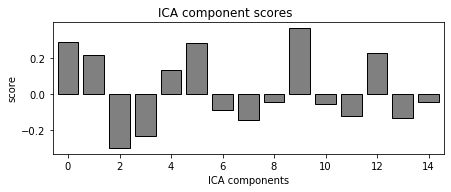

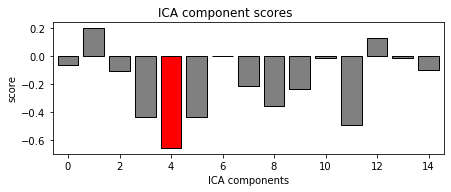

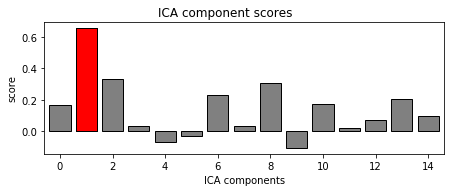

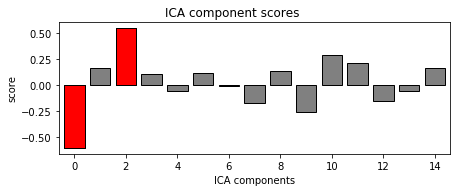

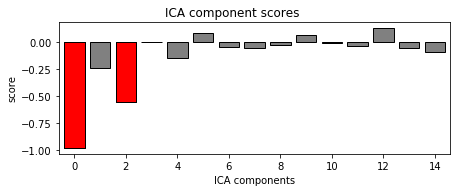

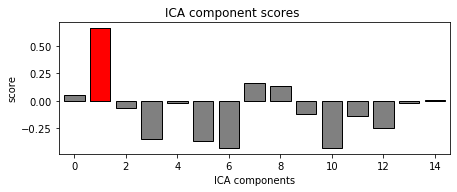

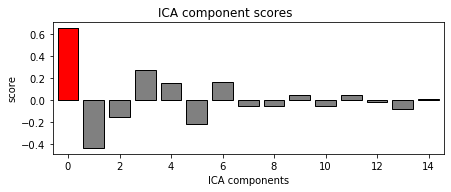

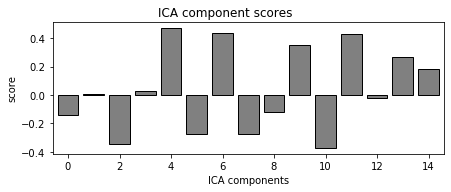

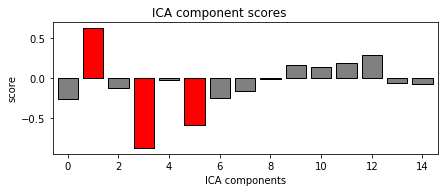

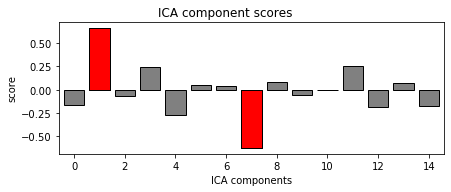

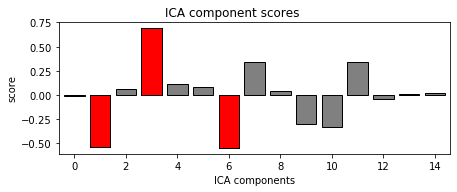

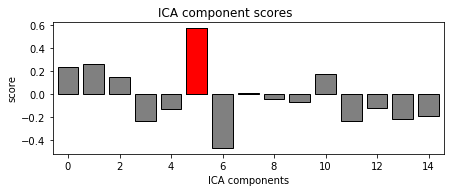

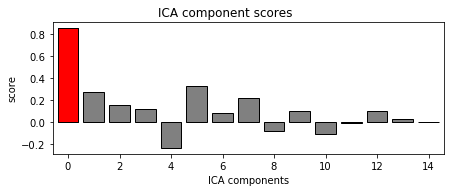

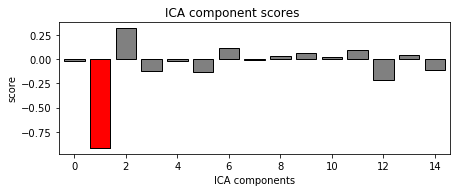

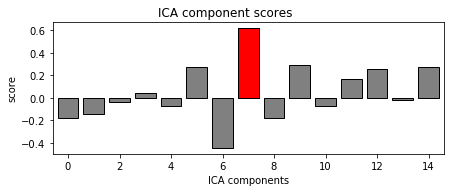

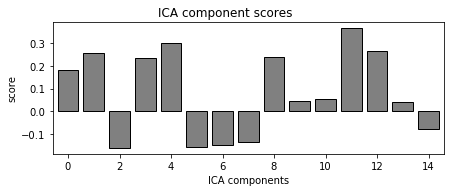

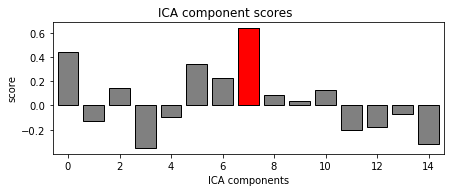

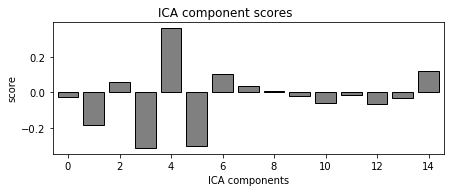

In [4]:
eeg_filename = 'eeg.mat'
feeltrace_filename = 'feeltrace.mat'
eeg_mat = [join(path_to_raw_eeg, f, eeg_filename) for f in listdir(path_to_raw_eeg) if isdir(f) and f[0] != '.']
montage = mne.channels.make_standard_montage('GSN-HydroCel-65_1.0')

for f in listdir(path_to_raw_eeg):
    if isdir(join(path_to_raw_eeg, f)) and f[0] != '.':
        try:
            pnum = f[:] # string
            print(pnum)


        #         load eeg mat file
            eeg_mat = join(path_to_raw_eeg, f, eeg_filename)
            eeg = loadmat(eeg_mat)
            eeg = eeg['eeg']

        #         create mne channel info
            channel_names = [ 'E' + str(i+1) for i in range(64)] + ['Cz']
            sampling_rate = 1000
            ch_types = 'eeg'
            info = mne.create_info(channel_names, sampling_rate, ch_types)

        #         load eeg into mne package
            raw = mne.io.RawArray(eeg.transpose()/(10 ** 6), info)
            raw.set_montage(montage)
            raw.set_channel_types({'E62': 'eog'})
            raw.drop_channels('Cz')
            
        #         filter eeg
            raw.notch_filter(np.arange(60, 301, 60), filter_length='auto',phase='zero')
            raw.filter(1, 250, picks=['eeg'])

        #         load feeltrace data
            feeltrace_mat = join(path_to_raw_eeg, f, feeltrace_filename)
            feeltrace = loadmat(feeltrace_mat)
            feeltrace = feeltrace['feeltrace']
            timestamps = feeltrace[:,0] / 1000 # in sec

            # crop eeg and filter
            trial_data = raw.copy().crop(max(0, timestamps[0]), min((raw.n_times - 1) / 1000, timestamps[-1]))
            print(trial_data.info)

            # EOG artifact removal through ICA
            eog_epochs = mne.preprocessing.create_eog_epochs(trial_data, baseline=(-0.5, -0.2))

            fig = eog_epochs.average().plot_joint()
            fig.savefig(join(path_to_figures, 'eog', 'epoch_average_E62', 'p' + pnum + '.png'))

            ica = ICA(n_components=15)
            ica.fit(trial_data)
            ica.plot_components(show=False)
            plt.savefig(join(path_to_figures, 'eog', 'ica_components', 'p' + pnum + '.png'))
            plt.close(None)


        #             repaired = raw.copy()
            eog_indices, eog_scores = ica.find_bads_eog(trial_data, ch_name='E62', measure='correlation', threshold=0.5)
            ica.exclude = eog_indices
            ica.plot_scores(eog_scores, show=False)
            plt.savefig(join(path_to_figures, 'eog', 'ica_component_scores', 'p' + pnum + '.png'))
            print(eog_indices)
            ica.apply(raw)

            np.savetxt(join('data', 'filtered_eeg', 'p' + pnum + '_eeg.csv'), raw.get_data().transpose())   
            
        except:
            print('\n\n\n\n\nparticipant', pnum, "encountered a problem\n\n\n\n")
            continue